In [68]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from astropy.cosmology import default_cosmology

from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.Util import data_util

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import lenstronomy_sim, survey_sim

In [69]:
pickle_path = os.path.join(config.machine.dir_00, 'detectable_gglenses_00.pkl')  # detectable_gglenses_01
detectable_gglenses = util.unpickle(pickle_path)

print(f'{len(detectable_gglenses)} detectable lens(es)')

40 detectable lens(es)


In [70]:
band='F106'

# sample_gglens = np.random.choice(detectable_gglenses)
sample_gglens = detectable_gglenses[0]
sample_lens = lens_util.slsim_lens_to_mejiro(sample_gglens, bands=[band], cosmo=default_cosmology.get())

pprint(sample_lens.lens_mags)
pprint(sample_lens.source_mags)

In [ ]:
import mejiro
from mejiro.helpers.roman_params import RomanParameters

module_path = os.path.dirname(mejiro.__file__)
csv_path = os.path.join(module_path, 'data', 'roman_spacecraft_and_instrument_parameters.csv')
roman_params = RomanParameters(csv_path)

In [ ]:
kwargs_model, kwargs_params = sample_gglens.lenstronomy_kwargs(band=band)

magnitude_zero_point = roman_params.get_ab_zeropoint(band)
lens_model = LensModel(kwargs_model['lens_model_list'])
source_light_model = LightModel(kwargs_model['source_light_model_list'])
lens_light_model = LightModel(kwargs_model['lens_light_model_list'])
kwargs_lens = kwargs_params['kwargs_lens']
kwargs_source = kwargs_params['kwargs_source']
kwargs_lens_light = kwargs_params['kwargs_lens_light']
kwargs_source_amp = data_util.magnitude2amplitude(source_light_model, kwargs_source, magnitude_zero_point)
kwargs_lens_light_amp = data_util.magnitude2amplitude(lens_light_model, kwargs_lens_light, magnitude_zero_point)

# set up image
num_pix = 45
fwhm = roman_params.get_psf_fwhm(band)
psf_class = PSF(**{'psf_type': 'GAUSSIAN', 'fwhm': fwhm})
kwargs_numerics = {
    'supersampling_factor': 1,
    'supersampling_convolution': False
}
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(
    numPix=num_pix,
    deltapix=0.11,
    subgrid_res=1,
    left_lower=False,
    inverse=False)
kwargs_pixel = {'nx': num_pix, 'ny': num_pix,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,
                'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': Mpix2coord}
pixel_grid = PixelGrid(**kwargs_pixel)
image_model = ImageModel(data_class=pixel_grid,
                            psf_class=psf_class,
                            lens_model_class=lens_model,
                            source_model_class=source_light_model,
                            lens_light_model_class=lens_light_model,
                            kwargs_numerics=kwargs_numerics)

# get surface brightness arrays
lens_surface_brightness = image_model.lens_surface_brightness(kwargs_lens_light_amp)
source_surface_brightness = image_model.source_surface_brightness(kwargs_source_amp, kwargs_lens)
total_image = image_model.image(kwargs_lens=kwargs_lens,
                                kwargs_source=kwargs_source_amp,
                                kwargs_lens_light=kwargs_lens_light_amp)

return total_image, lens_surface_brightness, source_surface_brightness

In [ ]:
total_image, _, source_surface_brightness = get_image(gglens, band)

# calculate region for source surface brightness array and count signal
stdev = np.std(source_surface_brightness)
mean = np.mean(source_surface_brightness)
mask = source_surface_brightness < mean + (mask_mult * stdev)
masked_source = np.ma.masked_array(source_surface_brightness, mask=mask)
sum_source_counts = np.sum(masked_source)

# get min zodiacal light and thermal background for given band
min_zodiacal_light = roman_params.get_min_zodi_count_rate(band)
thermal_background = roman_params.get_thermal_bkg(band)

# estimate and add background
estimated_background = (min_zodiacal_light * zodi_mult) + thermal_background  # in counts/pixel
estimated_background *= np.ones(total_image.shape)
total_image += estimated_background

# add noise
noise_180s = 5.5  # e- RMS, estimated total noise in 180s from https://roman.gsfc.nasa.gov/science/WFI_technical.html
noise_rms = noise_180s * (146 / 180)
noise_array = np.random.poisson(noise_rms, total_image.shape)
total_image += noise_array

# count total signal
masked_total = np.ma.masked_array(total_image, mask=mask)
sum_total_counts = np.sum(masked_total)

# calculate estimated SNR
return sum_source_counts / np.sqrt(sum_total_counts), total_image

In [1]:
raw_image, lens_surface_brightness, source_surface_brightness = survey_sim.get_image(sample_gglens, band=band)

plt.imshow(np.log10(raw_image))
plt.colorbar()
plt.show()

NameError: name 'survey_sim' is not defined

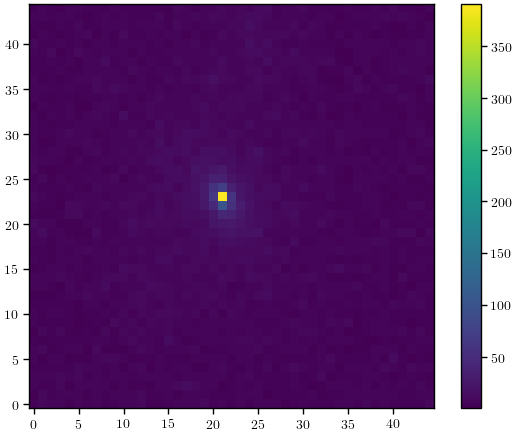

In [72]:
snr, total_image = survey_sim.get_snr(sample_gglens, band=band)

plt.imshow(total_image)
plt.colorbar()
plt.show()

In [73]:
pprint(sample_lens.kwargs_lens_light_dict)
pprint(sample_lens.kwargs_source_dict)

{'F106': {'R_sersic': 0.7335339884132732,
          'center_x': -0.1172427512305009,
          'center_y': 0.09685381539849834,
          'e1': -0.13163342197547978,
          'e2': -0.1660715064799798,
          'magnitude': 17.494719367667056,
          'n_sersic': 4.0}}
{'F106': {'R_sersic': 0.7229923747784959,
          'center_x': -0.24066959482314954,
          'center_y': 0.5553164675569033,
          'e1': -0.29815753134173323,
          'e2': 0.24862912159113534,
          'magnitude': 19.677038491097512,
          'n_sersic': 1.0}}


In [74]:
pprint(sample_lens.kwargs_lens)

[{'center_x': -0.1172427512305009,
  'center_y': 0.09685381539849834,
  'e1': -0.25684225696043245,
  'e2': -0.40951394659662765,
  'theta_E': 0.8770172205856541},
 {'dec_0': 0,
  'gamma1': -0.28036003151382594,
  'gamma2': 0.046899780519391296,
  'ra_0': 0},
 {'dec_0': 0, 'kappa': 0.09207184010507835, 'ra_0': 0}]


In [75]:
pprint(sample_lens.kwargs_model)

{'cosmo': FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897),
 'lens_light_model_list': ['SERSIC_ELLIPSE'],
 'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'],
 'lens_redshift_list': [0.139550137119465,
                        0.139550137119465,
                        0.139550137119465],
 'source_light_model_list': ['SERSIC_ELLIPSE'],
 'source_redshift_list': [0.40798411572801563],
 'z_source': 0.40798411572801563,
 'z_source_convention': 5}


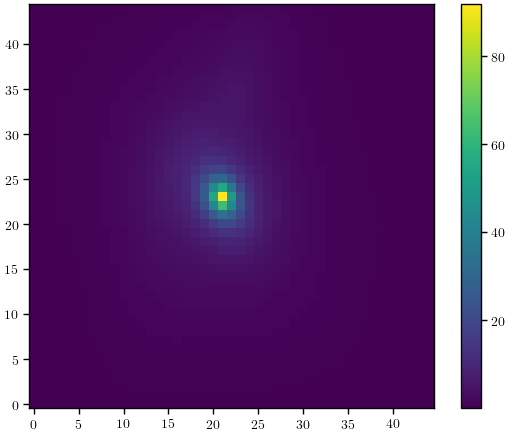

In [76]:
# image = lenstronomy_sim.get_image(sample_lens, 'roman', side=4.95)
from lenstronomy.SimulationAPI.ObservationConfig import Roman
from lenstronomy.SimulationAPI.sim_api import SimAPI

lens = sample_lens
side = 4.95

Roman_r = Roman.Roman(band='F106', psf_type='PIXEL', survey_mode='wide_area')
kwargs_r_band = Roman_r.kwargs_single_band()

sim_r = SimAPI(numpix=int(side / 0.11), kwargs_single_band=kwargs_r_band, kwargs_model=lens.kwargs_model)

kwargs_numerics = {'point_source_supersampling_factor': 1, 'supersampling_factor': 3}
imSim_r = sim_r.image_model_class(kwargs_numerics)

kwargs_lens_light = [lens.kwargs_lens_light_dict['F106']]
kwargs_source = [lens.kwargs_source_dict['F106']]

kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_r.magnitude2amplitude(kwargs_lens_light, kwargs_source)

image_r = imSim_r.image(lens.kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)

image_r += sim_r.noise_for_model(model=image_r)

plt.imshow(image_r)
plt.colorbar()
plt.show()

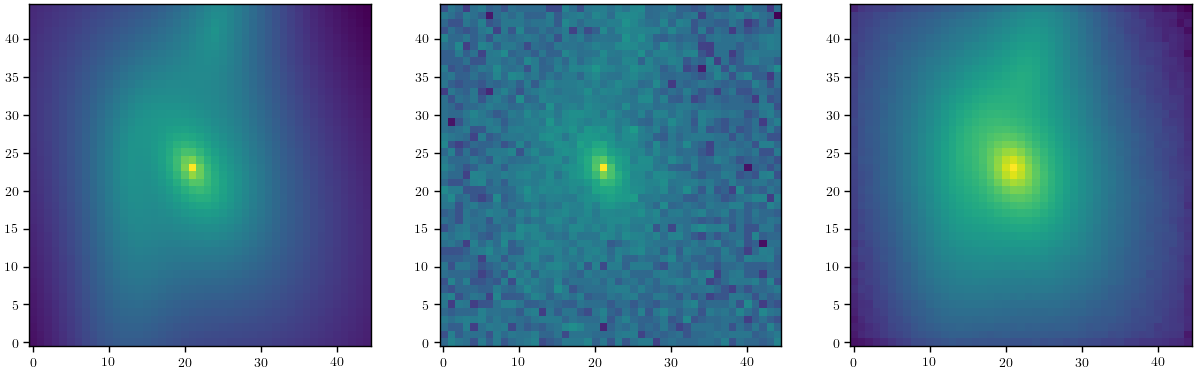

In [77]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(np.log10(raw_image))
ax[1].imshow(np.log10(total_image))
ax[2].imshow(np.log10(image_r))
plt.show()